# Longitudinal Beta Analysis of BSSu Percept recordings

## 0. Loading packages, defining paths

In [2]:
# Importing Python and external packages


import os
import sys
import importlib
from importlib import reload 
import json
from dataclasses import dataclass, field, fields
from itertools import compress
import csv
import pandas as pd
import numpy as np

import scipy
import matplotlib.pyplot as plt
from scipy import signal
from scipy.signal import spectrogram, hann, butter, filtfilt, freqz

import seaborn as sns
import pingouin as pg
from itertools import combinations
from statannotations.Annotator import Annotator

import openpyxl
from openpyxl import Workbook, load_workbook
import xlrd

#mne
import mne_bids
import mne
from mne.time_frequency import tfr_morlet 


# TODO: add README file: 
# pip install pingouin
# pip install statannotations
         


Set Path to load PyPerceive

In [3]:
#######################     USE THIS DIRECTORY FOR IMPORTING PYPERCEIVE REPO  #######################

# create a path to the BetaSenSightLongterm folder 
# and a path to the code folder within the BetaSenSightLongterm Repo
BetaSenSightLongterm_path = os.getcwd()
while BetaSenSightLongterm_path[-20:] != 'BetaSenSightLongterm':
    BetaSenSightLongterm_path = os.path.dirname(BetaSenSightLongterm_path)

# directory to PyPerceive code folder
PyPerceive_path = os.path.join(BetaSenSightLongterm_path, 'code', 'PyPerceive', 'code')
sys.path.append(PyPerceive_path)

# # change directory to PyPerceive code path within BetaSenSightLongterm Repo
os.chdir(PyPerceive_path)
os.getcwd()

'c:\\Users\\jebe12\\Research\\Longterm_beta_project\\Code\\BetaSenSightLongterm\\code\\PyPerceive\\code'

Load PyPerceive

In [4]:
from PerceiveImport.classes import (
    main_class, modality_class, metadata_class,
    session_class, condition_class, task_class,
    contact_class, run_class
)
import PerceiveImport.methods.load_rawfile as load_rawfile
import PerceiveImport.methods.find_folders as find_folders
import PerceiveImport.methods.metadata_helpers as metaHelpers


importlib.reload(main_class)
importlib.reload(session_class)
importlib.reload(task_class)
importlib.reload(condition_class)
importlib.reload(contact_class)
importlib.reload(metadata_class)
importlib.reload(modality_class)
importlib.reload(load_rawfile)
importlib.reload(find_folders)
importlib.reload(run_class)
importlib.reload(metaHelpers)

<module 'PerceiveImport.methods.metadata_helpers' from 'c:\\Users\\jebe12\\Research\\Longterm_beta_project\\Code\\BetaSenSightLongterm\\code\\PyPerceive\\code\\PerceiveImport\\methods\\metadata_helpers.py'>

Set Path back to BetaSenSightLongterm Repo

In [5]:
#######################     USE THIS DIRECTORY FOR WORKING WITH FOLDERS INSIDE OF CODE FOLDER OF BETASENSIGHTLONGTERM REPO  #######################


# create a path to the BetaSenSightLongterm folder 
# and a path to the code folder within the BetaSenSightLongterm Repo
BetaSenSightLongterm_path = os.getcwd()
while BetaSenSightLongterm_path[-20:] != 'BetaSenSightLongterm':
    BetaSenSightLongterm_path = os.path.dirname(BetaSenSightLongterm_path)

# directory to code folder
code_path = os.path.join(BetaSenSightLongterm_path, "code")
sys.path.append(code_path)

# # change directory to code path within BetaSenSightLongterm Repo
os.chdir(code_path)
os.getcwd()

'c:\\Users\\jebe12\\Research\\Longterm_beta_project\\Code\\BetaSenSightLongterm\\code'

Load analysis functions

In [36]:
import analysis.BSSuPsd as BSSuPsd
import analysis.FastFourierPSD as FFpsd
import analysis.MonoRef_JLB as MonoRefJLB
import analysis.loadCSVresults as loadcsv
import analysis.HighestRankedChannelPSD as highestRank
import analysis.GroupMonopolarPSD as groupMonopol
import analysis.PSDaverage_Comparisons as comparisonPSD

importlib.reload(BSSuPsd)
importlib.reload(MonoRefJLB)
importlib.reload(loadcsv)
importlib.reload(highestRank)
importlib.reload(groupMonopol)
importlib.reload(comparisonPSD)
importlib.reload(FFpsd)

<module 'analysis.FastFourierPSD' from 'c:\\Users\\jebe12\\Research\\Longterm_beta_project\\Code\\BetaSenSightLongterm\\code\\analysis\\FastFourierPSD.py'>

## 1. Calculate PSD averages of Beta, High Beta and Low Beta


	### WARNING: NaNs in Metadata Table sub-024 ###
NaNs in: sub024_ses-2021061806255999_run-BrainSense20210618063700.mat
NaNs in: sub024_ses-2021061806255999_run-BrainSense20210618064000.mat
NaNs in: sub024_ses-2021061806255999_run-BrainSense20210618064200.mat
NaNs in: sub024_ses-2021061808253999_run-BrainSense20210618084000.mat
NaNs in: sub024_ses-2021061808253999_run-BrainSense20210618084300.mat
NaNs in: sub024_ses-2021061808253999_run-BrainSense20210618084700.mat
NaNs in: sub024_ses-2021092106385396_run-BrainSense20210921070500.mat
NaNs in: sub024_ses-2021092106385396_run-BrainSense20210921072300.mat
NaNs in: sub024_ses-2021092106385396_run-CHRONIC20210917114914.mat
NaNs in: sub024_ses-2021092107452096_run-BrainSense20210921074800.mat
NaNs in: sub024_ses-2021092107452096_run-BrainSense20210921080600.mat
NaNs in: sub024_ses-2021092107452096_run-BrainSense20210921082400.mat
NaNs in: sub024_ses-2021092107452096_run-CHRONIC20210918121914.mat
NaNs in: sub-20210615PStn_ses-2022061010445782

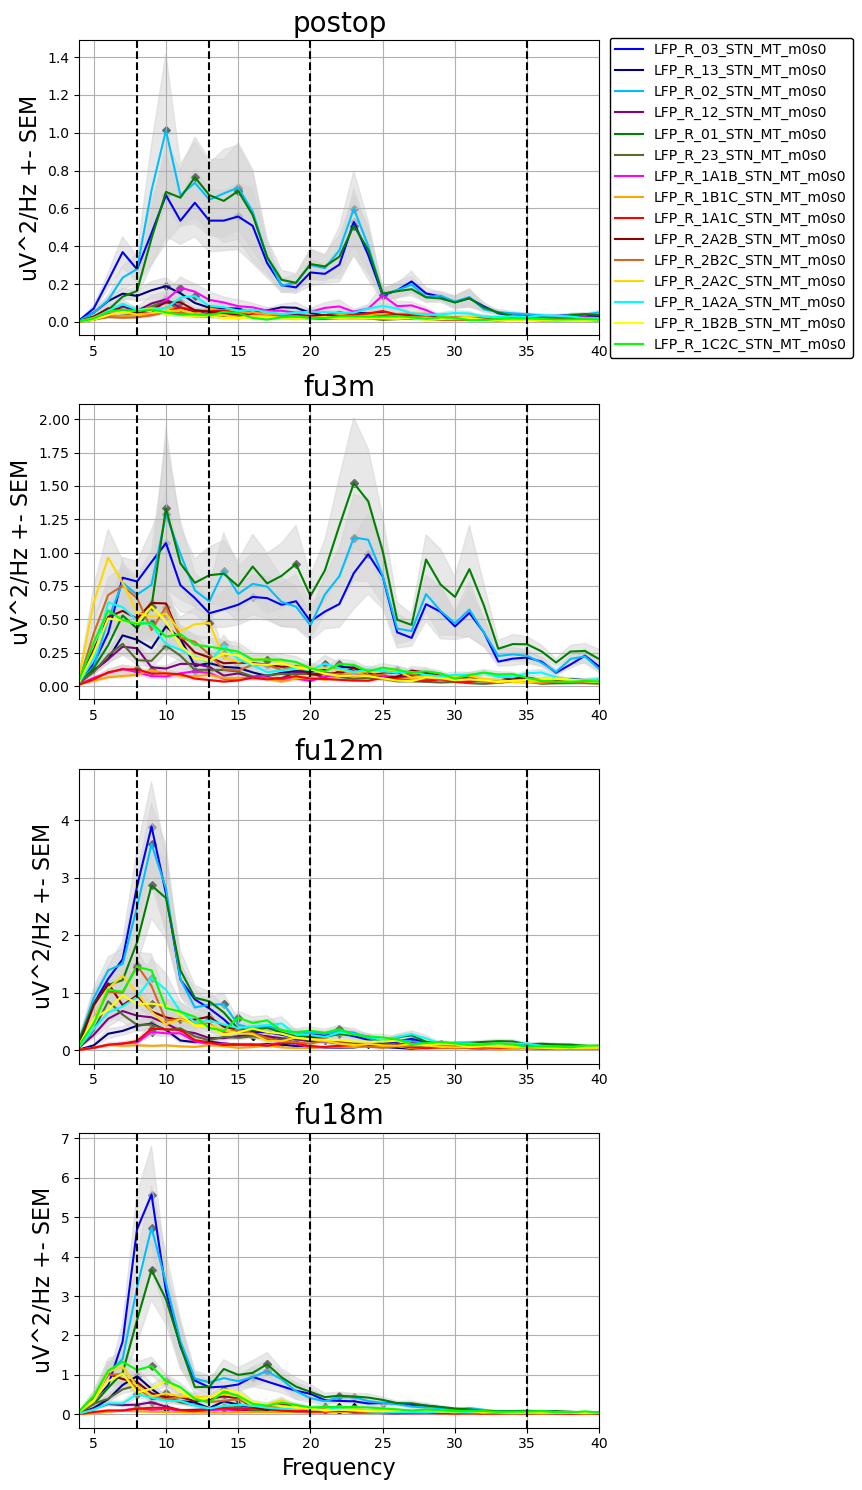

In [39]:
FF_psd_sub024 = FFpsd.spectrogram_Psd(
    incl_sub = "024", 
    incl_session = ["postop", "fu3m", "fu12m", "fu18m"],
    incl_condition = ["m0s0"],
    incl_contact=['RingR', 'SegmIntraR', 'SegmInterR'],
    pickChannels=['03', '13', '02', '12', '01', '23',
                  '1A1B', '1B1C', '1A1C', '2A2B', '2B2C', '2A2C',
                  '1A2A', '1B2B', '1C2C'],
    hemisphere="Right",
    normalization = "rawPSD",
    filter = "band-pass")

## 2. Load the PSD Data from results

In [33]:
PSDaverage_data = loadcsv.load_PSDresultCSV(
    sub="019",
    psdMethod="Spectrogram",
    normalization="rawPSD",
    hemisphere="Right")

In [35]:
#PSDaverage_data

Create three groups: Ring, SegmInter, SegmIntra
- 1. for each group plot the PSD average of each channel over time (x=session, y=PSD average), average PSD over channels within a group (+- standard deviation)
- 2. each group is a column, plot one channel per Row, within one subplot: Power spectrum of one channel at different timepoints